In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
from jax import random
from jax.scipy.special import erfinv
from jax.scipy.stats import norm

from assignment3.utils import metropolis_multiple_chains, save_array, load_array
from assignment3.exercise9 import compute_Rhat, compute_effective_sample_size

pics_output_path = lambda filename: os.path.join('assignment3', 'img', filename) 

In [2]:
# Load data
data = jnp.load(os.path.join('assignment3', 'data', 'data_exercise5b.npz'))
X = data['day']
y = jnp.log(data['bike_count'])
# remove mean and scale to unit variance
ym, ys = jnp.mean(y), jnp.std(y)
y = (y-ym)/ys

The Gaussian process regression model for the dataset $\mathcal{D} = \{(x_n, y_n)\}_{n=1}^N$ is given below:

$$
y_n = f(x_n) + \epsilon_n,
$$

where $\epsilon_n \sim \mathcal{N}(0, \sigma^2)$ and $f(x) \sim \mathcal{GP}(0, k(x,x'))$ for

$$
k(x,x') = \kappa^2 \exp\left( -\frac{\|x-x'\|^2}{2\ell^2} \right).
$$

We will impose the following prior distributions on the hyperparameters:

$$
\begin{aligned}
\kappa &\sim \mathcal{N}_+(0,1), \\
\ell &\sim \mathcal{N}_+(0,v), \\
\sigma &\sim \mathcal{N}_+(0,1),
\end{aligned}
$$

where $v>0$ is a positive constant (which you will determine in the next task) and $\mathcal{N}_+(m,v)$ is the half-normal distribution. These assumptions lead to the following joint distribution:

$$
\begin{aligned}
p(\mathbf{y}, \mathbf{f}, \sigma, \kappa, \ell) &= p(\mathbf{y}|\mathbf{f}, \sigma^2) p(\mathbf{f}|\kappa, \ell) p(\kappa) p(\ell) p(\sigma) \\
&= \mathcal{N}(\mathbf{y}|\mathbf{f}, \sigma^2\mathbf{I}) \mathcal{N}(\mathbf{f}|0,\mathbf{K}) \mathcal{N}_+(\kappa|0,1) \mathcal{N}_+(\ell|0,v) \mathcal{N}_+(\sigma|0,1).
\end{aligned}
$$

### Task 1.1 Choose a value for v such that the prior probability of observing a lengthscale larger than 100 is approximately 1%, i.e. $p(\ell > 100) \approx 0.01$
Since $\ell \sim \mathcal{N}_+(0, v) $ 
where CDF for the half-normal distribution is definied like so

$
cdf(x) = \operatorname{erf}\left( \frac{x}{v \sqrt{2}} \right)
$

$$
p(\ell > 100) \approx 0.01 \\

p(\ell > 100) = 1 - p(\ell \leq 100) = 1 - cdf(100) \approx 0.01
$$

$$
1 - cdf(100) = 1 - \operatorname{erf}\left( \frac{100}{v \sqrt{2}} \right)  \approx 0.01
$$

$$
\operatorname{erf}\left( \frac{100}{v \sqrt{2}} \right) = 0.99
$$

$$
\frac{100}{v \sqrt{2}} = \operatorname{erf}^{-1}\left( 0.99 \right)
$$

$$
v = \frac{100}{\sqrt{2} \operatorname{erf}^{-1}\left( 0.99 \right)}
$$

In [3]:
v = 100/(jnp.sqrt(2) * erfinv(0.99))
print(f'v = {v:3.2f}')

v = 38.82


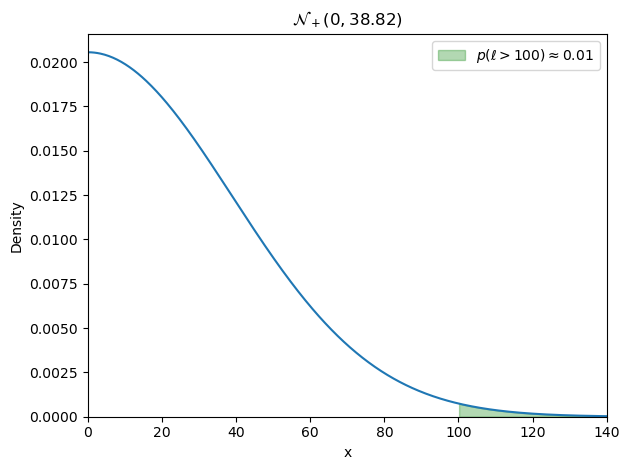

In [4]:
def halfnormal_pdf(x, sigma):
    return jnp.sqrt(2) / (sigma * jnp.sqrt(jnp.pi)) * jnp.exp(-x**2 / (2 * sigma**2))

x = jnp.linspace(0, 140, 500)
pdfs = halfnormal_pdf(x, 38.82)
plt.plot(x, pdfs)
plt.fill_between(x[x >= 100], pdfs[x >= 100], color='green', alpha=0.3, label=r'$p(\ell > 100) \approx 0.01$')
plt.title(r'$\mathcal{N}_+(0, 38.82)$')
plt.xlabel('x')
plt.ylabel('Density')
plt.xlim(0,140)
plt.ylim(0)
plt.tight_layout()
plt.legend()
plt.savefig(pics_output_path('img11.png'), dpi=300)

### Task 1.2: Determine the marginalized distribution $p(\mathbf{y}, \sigma, \kappa, \ell)$

We use the same reasoning as described in Murphy (3.3)

$$
p(\mathbf{y}, \sigma, \kappa, \ell) = \int p(\mathbf{y}, \mathbf{f}, \sigma, \kappa, \ell)\, d\mathbf{f} = \\ \int \mathcal{N}(\mathbf{y}|\mathbf{f}, \sigma^2\mathbf{I}) \mathcal{N}(\mathbf{f}|0,\mathbf{K}) \mathcal{N}_+(\kappa|0,1) \mathcal{N}_+(\ell|0,v) \mathcal{N}_+(\sigma|0,1) \,d\mathbf{f} = \\

\mathcal{N}(\mathbf{y}|\mathbf{0}, \sigma^2\mathbf{I} + \mathbf{K}) \mathcal{N}_+(\kappa|0,1) \mathcal{N}_+(\ell|0,v) \mathcal{N}_+(\sigma|0,1)
$$

The next goal is to approximate the posterior distribution over the hyperparameters, i.e.\ $p(\kappa, \ell, \sigma \mid \mathbf{y})$, using a Metropolis-sampler. Define $\theta = \{\kappa, \ell, \sigma^2\}$ to be the set of hyperparameters of the model. Since the scale of the hyperparameters are quite different, we will use an anisotropic proposal distribution:

$$
q(\theta^\ast \mid \theta^{k-1}) = \mathcal{N}(\theta^\ast \mid \theta^{k-1}, \boldsymbol{\Sigma}) \quad \text{for} \quad \boldsymbol{\Sigma} = \frac{1}{2}
\begin{bmatrix}
1 & 0 & 0 \\
0 & 100 & 0 \\
0 & 0 & 0.01
\end{bmatrix}.
\tag{2}
$$

That is, the proposed step-size will generally be larger for the lengthscale dimension and so on.

### Task 1.3: Implement a Metropolis sampler using the proposal distribution in eq. (2) for generating samples from the posterior $p(\kappa, \ell, \sigma|\mathbf{y})$. Run 4 chains for 10000 iterations each

First of all, using the Bayes' theorem we can notice that

$$
p(\kappa, \ell, \sigma \mid \mathbf{y}) \propto p(\mathbf{y} \mid \kappa, \ell, \sigma) p(\kappa, \ell, \sigma) = p(\mathbf{y}, \kappa, \ell, \sigma)
$$

$$
\log p(\mathbf{y}, \kappa, \ell, \sigma) = \log \mathcal{N}(\mathbf{y}|\mathbf{0}, \sigma^2\mathbf{I} + \mathbf{K}) + \log \mathcal{N}_+(\kappa|0,1) + \log \mathcal{N}_+(\ell|0,v) + \log \mathcal{N}_+(\sigma|0,1)
$$

In [ ]:
from jax.scipy.stats.multivariate_normal import logpdf as mvn_logpdf

def log_halfnormal(x, scale):
    return jnp.where(x > 0,
                     jnp.log(2.0) + norm.logpdf(x, loc=0.0, scale=scale),
                     -jnp.inf)
    

def compute_K(kappa, lengthscale):
    X_norm = jnp.sum(X**2, axis=1)
    sq_dists = -2 * jnp.dot(X, X.T) + X_norm[:, None] + X_norm[None, :]
    
    K = (kappa**2) * jnp.exp(-0.5 * sq_dists / lengthscale**2)
    
    return K


def log_joint(theta):
    kappa, lengthscale, sigma_sq = theta
    
    N = y.shape[0]
    cov = sigma_sq * jnp.eye(N) + compute_K(kappa, lengthscale)
    
    log_prob_y = mvn_logpdf(y.ravel(), mean=jnp.zeros(N), cov=cov)
        
    # Log-priors
    log_prior_kappa = log_halfnormal(kappa, scale=1.0)
    log_prior_l = log_halfnormal(lengthscale, scale=v)
    log_prior_sigma = log_halfnormal(jnp.sqrt(sigma_sq), scale=1.0)
    
    return log_prob_y + log_prior_kappa + log_prior_l + log_prior_sigma

In [7]:
num_chains = 4
num_iterations = 10000
tau = 0.5 * jnp.array([1., 100., 0.01])
theta_init = jnp.full((num_chains, 3), 10.0)

thetas, accepts = metropolis_multiple_chains(
    log_target=log_joint,
    num_params=3,
    num_chains=num_chains,
    tau=tau,
    num_iter=num_iterations,
    theta_init=theta_init,
    seeds=jnp.arange(num_chains)
)

In [8]:
# Saving locally to avoid unnecessary calculations
save_array(thetas, 'thetas-task13.npy')
save_array(accepts, 'accepts-task13.npy')

In [9]:
# Loading pre-calculated params
thetas = load_array('thetas-task13.npy')
accepts = load_array('accepts-task13.npy')

###  Task 1.4: Plot the trace for each parameter and report the convergence diagnostics $\hat{R}$ and $S_{eff}$ for each parameter. Discard warm-up samples and report the number of samples discarded

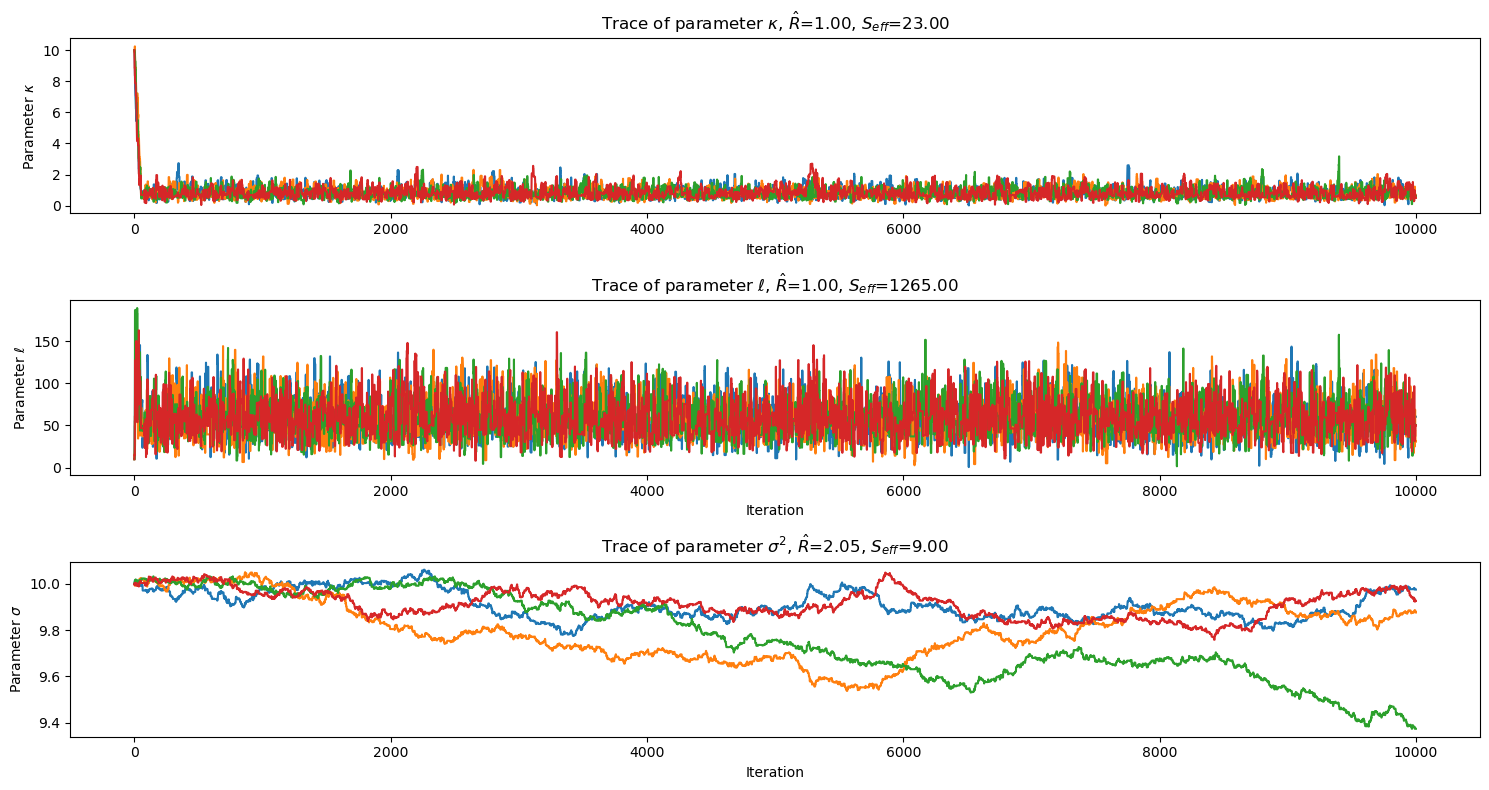

In [10]:
Rhats = compute_Rhat(thetas)
Seffs = compute_effective_sample_size(thetas)

fig, axes = plt.subplots(3, 1, figsize=(15, 8))

conv_diagnostic_str = lambda i: fr'$\hat{{R}}$={Rhats[i]:3.2f}, $S_{{eff}}$={Seffs[i]:3.2f}'

params = [
    (r'Parameter $\kappa$', fr'Trace of parameter $\kappa$, {conv_diagnostic_str(0)}'),
    (r'Parameter $\ell$',fr'Trace of parameter $\ell$, {conv_diagnostic_str(1)}'),
    (r'Parameter $\sigma$', fr'Trace of parameter $\sigma^{2}$, {conv_diagnostic_str(2)}')
]

for chain in thetas:
    for i, (ylabel, title) in enumerate(params):
        axes[i].plot(chain[:,i])
        axes[i].set_xlabel('Iteration')
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(title)
    
fig.tight_layout()
plt.savefig(pics_output_path('img14-with-warmup.png'), dpi=300)

Warm-up is: 500


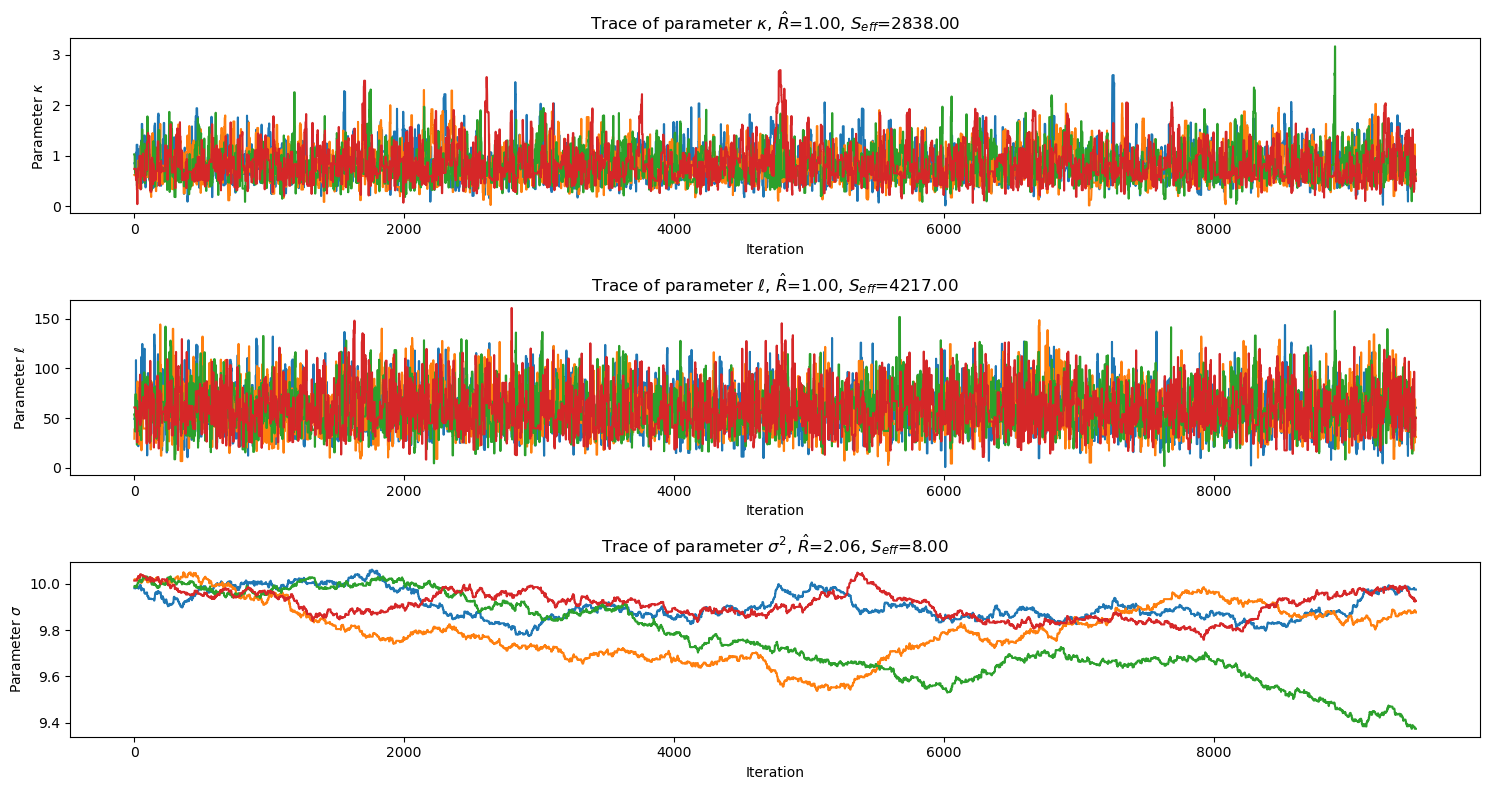

In [11]:
# The same result but after warm-up
warm_up = int(0.05 * num_iterations) 
thetas_no_warmup = thetas[:, warm_up:, :]

Rhats = compute_Rhat(thetas_no_warmup)
Seffs = compute_effective_sample_size(thetas_no_warmup)

fig, axes = plt.subplots(3, 1, figsize=(15, 8))

conv_diagnostic_str = lambda i: fr'$\hat{{R}}$={Rhats[i]:3.2f}, $S_{{eff}}$={Seffs[i]:3.2f}'

params = [
    (r'Parameter $\kappa$', fr'Trace of parameter $\kappa$, {conv_diagnostic_str(0)}'),
    (r'Parameter $\ell$',fr'Trace of parameter $\ell$, {conv_diagnostic_str(1)}'),
    (r'Parameter $\sigma$', fr'Trace of parameter $\sigma^{2}$, {conv_diagnostic_str(2)}')
]

for chain in thetas_no_warmup:
    for i, (ylabel, title) in enumerate(params):
        axes[i].plot(chain[:,i])
        axes[i].set_xlabel('Iteration')
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(title)
    
fig.tight_layout()
plt.savefig(pics_output_path('img14-no-warmup.png'), dpi=300)

print(f'Warm-up is: {warm_up}')

### Task 1.5: Estimate and report the posterior mean for each hyperparameter. Report the MCSE for each estimate.

In [12]:
posterior_means = jnp.mean(thetas, axis=(0, 1))

estimated_var = jnp.var(thetas, axis=(0, 1))
estimated_std = jnp.sqrt(estimated_var)

mcse = estimated_std/jnp.sqrt(Seffs)

In [13]:
for i, param in enumerate(['kappa', 'l', 'sigma']):
    print(f'({param}) - Estimated mean: {posterior_means[i]:3.2f}, MCSE: {mcse[i]:3.2f}')

(kappa) - Estimated mean: 0.84, MCSE: 0.01
(l) - Estimated mean: 58.81, MCSE: 0.34
(sigma) - Estimated mean: 9.85, MCSE: 0.05


### Task 1.6: Estimate a 95% posterior credibility interval for each hyperparameter.

In [14]:
thetas_flat = thetas.reshape(-1, 3)

lower = jnp.percentile(thetas_flat, 2.5, axis=0)
upper = jnp.percentile(thetas_flat, 97.5, axis=0)

credibility_intervals = jnp.stack([lower, upper], axis=1)

for i, param in enumerate(['kappa', 'l', 'sigma']):
    print(f'{param}: {credibility_intervals[i].round(2)}')

kappa: [0.32 1.66]
l: [ 21.66 106.81]
sigma: [ 9.54      10.0199995]
